* In this section we are trying to predict the surface air temperature map using gridded satellite and reanalysis greenhouse gases (CO2, CH4, N2O) dataset.
* Models used for this investigation include CNN (Convolutional Neural Network), LSTM (Long-Short Term Memory) and CNN-LSTM.
* The code is runned after the report is submitted. Therefore, the values might be different from the written report.

### Settings

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install netCDF4 h5py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.4 MB/s eta 0:00:00


In [4]:
!pip install keras-tuner --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 1.1 MB/s eta 0:00:00


In [5]:
#Libraries
import netCDF4 as nc
import h5py
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
from scipy.ndimage import zoom
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

#Dataset
from sklearn.model_selection import train_test_split

#CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, AveragePooling2D, GlobalAveragePooling2D, Dense, Activation, Reshape
import tensorflow as tf

#hyperparamete tuning
import keras_tuner

* Dataset
  - organized_data_final.nc is data organized dataset containing CO2, CH4, N2O monthly values from 2015.01 ~ 2022.02.
  - Specific process of how datasets are achieved and are preprocessed are written in "Settings/Visualization" file.


In [6]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [7]:
all_data = nc.Dataset('organized_data_final.nc')

In [8]:
variable_names = all_data.variables.keys()
print(variable_names)

dict_keys(['lat', 'lon', 'time', 'year_month', 'co2_data', 'ch4_data', 'n2o_data', 'temp_data'])


In [9]:
for var_name in variable_names:
    var = all_data.variables[var_name]
    data_type = var.dtype
    data_structure = var.shape
    print(f"Variable Name: {var_name}, Data Type: {data_type}, Data Structure : {data_structure}")

Variable Name: lat, Data Type: float32, Data Structure : (180,)
Variable Name: lon, Data Type: float32, Data Structure : (360,)
Variable Name: time, Data Type: int32, Data Structure : (86,)
Variable Name: year_month, Data Type: <class 'str'>, Data Structure : (86,)
Variable Name: co2_data, Data Type: float32, Data Structure : (86, 180, 360)
Variable Name: ch4_data, Data Type: float32, Data Structure : (86, 180, 360)
Variable Name: n2o_data, Data Type: float32, Data Structure : (86, 180, 360)
Variable Name: temp_data, Data Type: float32, Data Structure : (86, 180, 360)


In [10]:
co2 = all_data.variables['co2_data'][:]
ch4 = all_data.variables['ch4_data'][:]
n2o = all_data.variables['n2o_data'][:]
temp = all_data.variables['temp_data'][:]
year_month = all_data.variables['year_month'][:]

In [11]:
year_month

array(['2015-01', '2015-02', '2015-03', '2015-04', '2015-05', '2015-06',
       '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12',
       '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06',
       '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12',
       '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06',
       '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12',
       '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06',
       '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12',
       '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06',
       '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12',
       '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06',
       '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12',
       '2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06',
       '2021-07', '2021-08', '2021-09', '2021-10', 

# Datasets
- We wish to see how gridded greenhouse gas datasets can effectively estimate surface temperature datasets.
- For Model 1, all CO2, CH4, N2O datasets are combined.

* Predictor

In [12]:
# Combine datsets (CO2, CH4, N2O)
data_combined = np.stack([co2, ch4, n2o], axis=-1)

In [13]:
data_combined.shape

(86, 180, 360, 3)

* Predictand

In [14]:
temp.shape

(86, 180, 360)

# Models

## 1) Convolutional Neural Networks

In [75]:
# Split data (train, test)
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(data_combined, temp, test_size=0.15, random_state=42)

In [76]:
# Standardization
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df
X_test = X_test_df
y_train = y_train_df
y_test = y_test_df

In [77]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(73, 180, 360, 3) (73, 180, 360) (13, 180, 360, 3) (13, 180, 360)


* Code reference from https://github.com/leap-stc/EAEE4000_ML_for_Env_Eng_Sci

In [79]:
n_filters   = 20 # number of filters
kernel_size = 3  # kernel size for Covolutional layers
pool_size   = 2  # size for average pooling layers
activation  = 'relu' # activation function
learning_rate = 0.001 # learning rate

In [78]:
model_cnn = Sequential()

model_cnn.add(Input(shape=(180, 360, 3)))
model_cnn.add(Conv2D(n_filters, (kernel_size, kernel_size), padding='same', activation=activation))
model_cnn.add(AveragePooling2D(pool_size))
model_cnn.add(GlobalAveragePooling2D())
model_cnn.add(Dense(180 * 360))
model_cnn.add(Activation('linear'))
model_cnn.add(Reshape((1, 180, 360)))

model_cnn.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
model_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 180, 360, 20)      560       
                                                                 
 average_pooling2d_3 (Avera  (None, 90, 180, 20)       0         
 gePooling2D)                                                    
                                                                 
 global_average_pooling2d_3  (None, 20)                0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 64800)             1360800   
                                                                 
 activation_3 (Activation)   (None, 64800)             0         
                                                                 
 reshape_3 (Reshape)         (None, 1, 180, 360)      

In [80]:
from tensorflow import keras

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model_cnn.fit(X_train, y_train, batch_size = 10, epochs = 300, validation_split=0.2, verbose=1, callbacks=[early_stop])

Epoch 1/300
6/6 [==============================] - 1s 46ms/step - loss: 278.5564 - val_loss: 278.0081
Epoch 2/300
6/6 [==============================] - 0s 19ms/step - loss: 278.5128 - val_loss: 277.9539
Epoch 3/300
6/6 [==============================] - 0s 21ms/step - loss: 278.4499 - val_loss: 277.8770
Epoch 4/300
6/6 [==============================] - 0s 20ms/step - loss: 278.3618 - val_loss: 277.7712
Epoch 5/300
6/6 [==============================] - 0s 21ms/step - loss: 278.2424 - val_loss: 277.6308
Epoch 6/300
6/6 [==============================] - 0s 19ms/step - loss: 278.0859 - val_loss: 277.4488
Epoch 7/300
6/6 [==============================] - 0s 19ms/step - loss: 277.8846 - val_loss: 277.2173
Epoch 8/300
6/6 [==============================] - 0s 19ms/step - loss: 277.6303 - val_loss: 276.9270
Epoch 9/300
6/6 [==============================] - 0s 20ms/step - loss: 277.3130 - val_loss: 276.5693
Epoch 10/300
6/6 [==============================] - 0s 19ms/step - loss: 276.9259 

In [81]:
loss = model_cnn.evaluate(X_test, y_test)
print(f'Mean Averaged Error on Test Data: {loss}')

1/1 [==============================] - 0s 42ms/step - loss: 5.6065
Mean Averaged Error on Test Data: 5.606496334075928


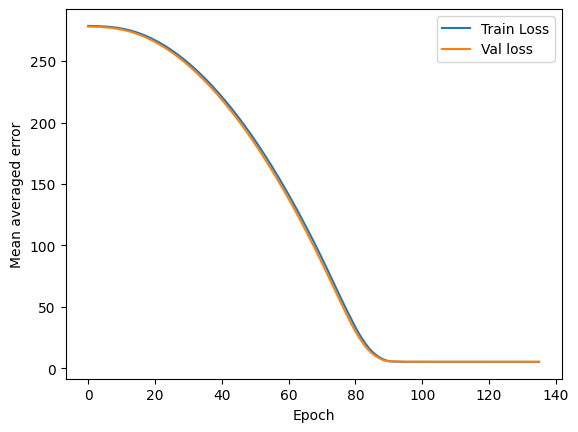

In [82]:
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean averaged error')
plt.plot(history.epoch, np.array(history.history['loss']), label='Train Loss')
plt.plot(history.epoch, np.array(history.history['val_loss']), label = 'Val loss')
plt.legend()

## Testing model

In [83]:
y_pred = model_cnn.predict(X_test)

1/1 [==============================] - 0s 58ms/step


In [84]:
y_pred.shape

(13, 1, 180, 360)

In [85]:
y_pred_reshaped = y_pred.reshape((y_test.shape[0], 180, 360))
y_test_reshaped= y_test.reshape((y_test.shape[0], 180, 360))

In [86]:
y_pred_reshaped.shape

(13, 180, 360)

In [87]:
y_test.shape

(13, 180, 360)

In [88]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test_reshaped[2], y_pred_reshaped[2])
print(f"R^2 Score: {r2}")

R^2 Score: 0.8924845790666597


In [89]:
#Change of scale
#y_test_original_scale = (y_test_reshaped * std2) + mean2
y_pred_original_scale = (y_pred_reshaped * std) + mean

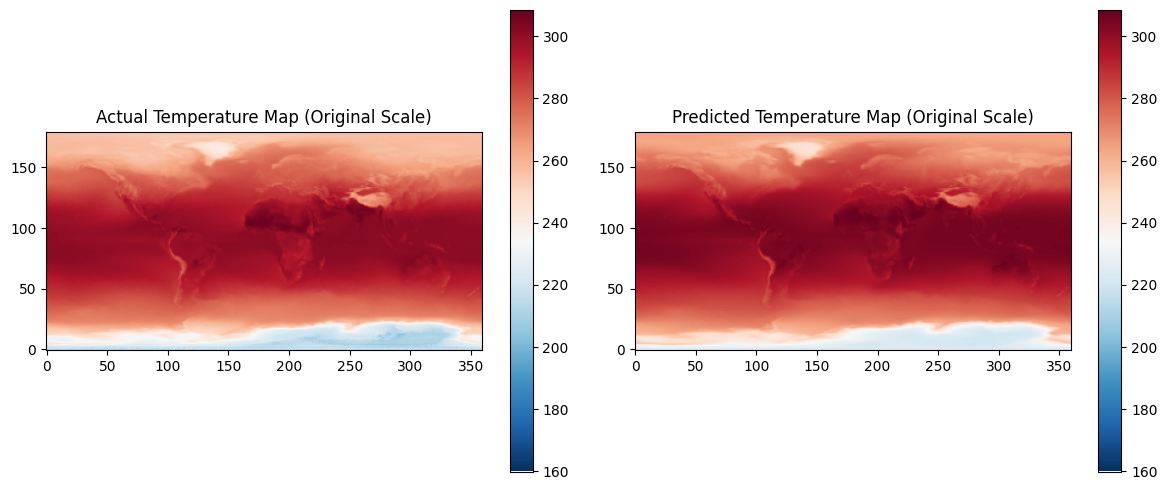

In [90]:
import matplotlib.pyplot as plt

# Choose a time step to visualize (e.g., first time step)
time_step_index = 0


# Determine the common color scale limits based on the actual data
common_vmin = min(y_test_reshaped[time_step_index].min(), y_pred_original_scale[time_step_index].min())
common_vmax = max(y_test_reshaped[time_step_index].max(), y_pred_original_scale[time_step_index].max())

# Plot actual temperature map
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(y_test_reshaped[time_step_index].reshape((180, 360)), cmap='RdBu_r', vmin=160, vmax=common_vmax)
plt.title('Actual Temperature Map (Original Scale)')
plt.gca().invert_yaxis()
plt.colorbar()

# Plot predicted temperature map
plt.subplot(1, 2, 2)
plt.imshow(y_pred_reshaped[time_step_index], cmap='RdBu_r', vmin=160, vmax=common_vmax)
plt.title('Predicted Temperature Map (Original Scale)')
plt.colorbar()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Hyperparameter Tuning

In [47]:
n_trials       = 5
kernel_size = 3  # kernel size for Covolutional layers
learning_rate = 0.001 # learning rate
minibatch_size = 10   # batch size
num_epochs     = 300   # number of total epochs

In [48]:
def build_model(hp):

    # options for hyperparameters
    hp_filters = hp.Choice('filters', values=[16,32,64])
    hp_kernel_size = hp.Choice('kernel_size', values=[2,3,4,5])
    hp_pool_size = hp.Choice('pool_size', values=[2,3,4,5])
    hp_activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    hp_loss = hp.Choice('loss', values=['mse','mae'])

    # build CNN models according to the hyperparameters
    model_cnn = keras.models.Sequential()

    model_cnn.add(Input(shape=(n_lat, n_lon, n_feature)))
    model_cnn.add(Conv2D(hp_filters, kernel_size=hp_kernel_size, padding='same', activation=hp_activation))
    model_cnn.add(AveragePooling2D(hp_pool_size))
    model_cnn.add(GlobalAveragePooling2D())
    model_cnn.add(Dense(n_lat * n_lon))
    model_cnn.add(Activation('linear'))
    model_cnn.add(Reshape((1, n_lat, n_lon)))

    model_cnn.compile(loss=hp_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate))

    return model_cnn


In [91]:
random_tuner = keras_tuner.RandomSearch(build_model, max_trials=n_trials, seed=5, objective='val_loss', max_retries_per_trial=0, max_consecutive_failed_trials=3, directory='RS', project_name='RS_1')

In [92]:
random_tuner.search_space_summary()

Search space summary
Default search space size: 6
filters (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
kernel_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 4, 5], 'ordered': True}
pool_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 4, 5], 'ordered': True}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001, 1e-05], 'ordered': True}
loss (Choice)
{'default': 'mse', 'conditions': [], 'values': ['mse', 'mae'], 'ordered': False}


In [93]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [94]:
# Perform hypertuning
random_tuner.search(X_train, y_train,
                    batch_size = minibatch_size,
                    epochs = num_epochs,
                    validation_split = 0.2,
                    callbacks = [early_stop])

Trial 5 Complete [00h 01m 25s]
val_loss: 208.46420288085938

Best val_loss So Far: 4.671534061431885
Total elapsed time: 00h 06m 48s


In [95]:
# Best model
best_model = random_tuner.get_best_models()[0]
best_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 360, 32)      416       
                                                                 
 average_pooling2d (Average  (None, 45, 90, 32)        0         
 Pooling2D)                                                      
                                                                 
 global_average_pooling2d (  (None, 32)                0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 64800)             2138400   
                                                                 
 activation (Activation)     (None, 64800)             0         
                                                                 
 reshape (Reshape)           (None, 1, 180, 360)       0

In [96]:
# check hyperparameters of the all tuning trials
all_hps = random_tuner.get_best_hyperparameters(num_trials=n_trials)

# print the hyperparameters of the top 1 tuning trial
for it in range(1):
    print("Ranking #", str(it+1).zfill(1), "of best tuning, total trials = ", str(n_trials))
    print(all_hps[it].values)
    print("=============================================================================================")


# Hyperparameters of the best model
best_hps = random_tuner.get_best_hyperparameters(num_trials=n_trials)[0]

Ranking # 1 of best tuning, total trials =  5
{'filters': 32, 'kernel_size': 2, 'pool_size': 4, 'activation': 'sigmoid', 'learning_rate': 0.01, 'loss': 'mae'}
Ranking # 2 of best tuning, total trials =  5
{'filters': 32, 'kernel_size': 5, 'pool_size': 3, 'activation': 'relu', 'learning_rate': 0.001, 'loss': 'mae'}
Ranking # 3 of best tuning, total trials =  5
{'filters': 32, 'kernel_size': 4, 'pool_size': 2, 'activation': 'relu', 'learning_rate': 0.0001, 'loss': 'mae'}


In [97]:
## Build the model with the optimal hyperparameters
# ---------- best tuning ----------
model_best = random_tuner.hypermodel.build(best_hps)

# ---------- ranking #2 tuning ----------
model_top2 = random_tuner.hypermodel.build(top2_hps)



## re-train the model
# ---------- best tuning ----------
history_best = model_best.fit(X_train, y_train,
                              batch_size      = minibatch_size,
                              epochs          = num_epochs,
                              validation_split= 0.2,
                              verbose         = 1,
                              callbacks       = [early_stop])
# ---------- ranking #2 tuning ----------
history_top2 = model_top2.fit(X_train, y_train,
                              batch_size      = minibatch_size,
                              epochs          = num_epochs,
                              validation_split= 0.2,
                              verbose         = 1,
                              callbacks       = [early_stop])


Epoch 1/300
6/6 [==============================] - 1s 61ms/step - loss: 278.2004 - val_loss: 276.9916
Epoch 2/300
6/6 [==============================] - 0s 25ms/step - loss: 276.8929 - val_loss: 275.3350
Epoch 3/300
6/6 [==============================] - 0s 24ms/step - loss: 275.0518 - val_loss: 273.2726
Epoch 4/300
6/6 [==============================] - 0s 24ms/step - loss: 272.9099 - val_loss: 271.0568
Epoch 5/300
6/6 [==============================] - 0s 24ms/step - loss: 270.6845 - val_loss: 268.8329
Epoch 6/300
6/6 [==============================] - 0s 22ms/step - loss: 268.4714 - val_loss: 266.6368
Epoch 7/300
6/6 [==============================] - 0s 23ms/step - loss: 266.2862 - val_loss: 264.4669
Epoch 8/300
6/6 [==============================] - 0s 30ms/step - loss: 264.1252 - val_loss: 262.3181
Epoch 9/300
6/6 [==============================] - 0s 21ms/step - loss: 261.9838 - val_loss: 260.1872
Epoch 10/300
6/6 [==============================] - 0s 21ms/step - loss: 259.8593 

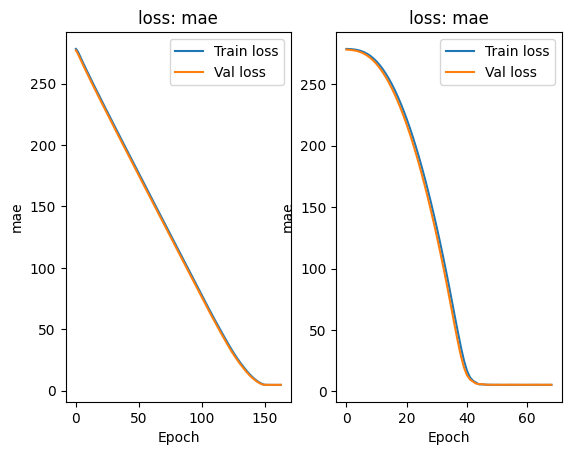

In [56]:
## set up title and ylabel strings
# ---------- best tuning ----------
title_best = 'loss: '+str(best_hps['loss'])
ylabel_best = best_hps['loss']
# ---------- ranking #2 tuning ----------
title_top2 = 'loss: '+str(top2_hps['loss'])
ylabel_top2 = top2_hps['loss']


## plot history
# ---------- best tuning ----------
plt.subplot(1, 2, 1)
plt.plot(history_best.history['loss'])
plt.plot(history_best.history['val_loss'])
plt.title(title_best, fontsize=12)
plt.ylabel(ylabel_best)
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], fontsize=10, loc='upper right')

# ---------- ranking #2 tuning ----------
plt.subplot(1, 2, 2)
plt.plot(history_top2.history['loss'])
plt.plot(history_top2.history['val_loss'])
plt.title(title_top2, fontsize=12)
plt.ylabel(ylabel_top2)
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], fontsize=10, loc='upper right')


## Testing model

In [98]:
y_pred = model_best.predict(X_test)

1/1 [==============================] - 0s 59ms/step


In [99]:
y_pred.shape

(13, 1, 180, 360)

In [100]:
y_pred_reshaped = y_pred.reshape((y_test.shape[0], 180, 360))
y_test_reshaped= y_test.reshape((y_test.shape[0], 180, 360))

In [101]:
y_pred_reshaped.shape

(13, 180, 360)

In [102]:
y_test.shape

(13, 180, 360)

In [103]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test_reshaped[2], y_pred_reshaped[2])
print(f"R^2 Score: {r2}")

R^2 Score: 0.9171171218985231


In [104]:
#Change of scale
#y_test_original_scale = (y_test_reshaped * std2) + mean2
y_pred_original_scale = (y_pred_reshaped * std) + mean

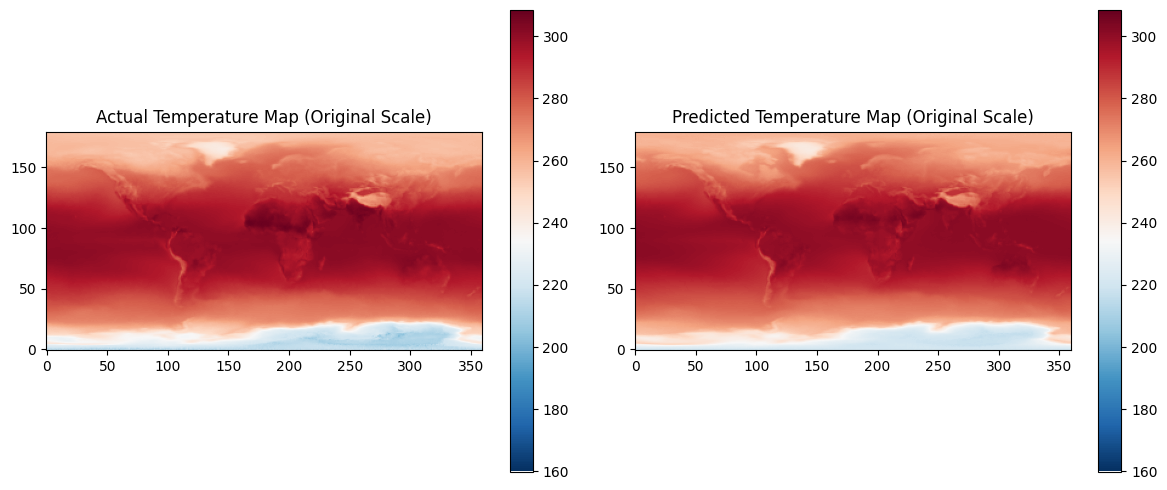

In [105]:
import matplotlib.pyplot as plt

# Choose a time step to visualize (e.g., first time step)
time_step_index = 0


# Determine the common color scale limits based on the actual data
common_vmin = min(y_test_reshaped[time_step_index].min(), y_pred_original_scale[time_step_index].min())
common_vmax = max(y_test_reshaped[time_step_index].max(), y_pred_original_scale[time_step_index].max())

# Plot actual temperature map
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(y_test_reshaped[time_step_index].reshape((180, 360)), cmap='RdBu_r', vmin=160, vmax=common_vmax)
plt.title('Actual Temperature Map (Original Scale)')
plt.gca().invert_yaxis()
plt.colorbar()

# Plot predicted temperature map
plt.subplot(1, 2, 2)
plt.imshow(y_pred_reshaped[time_step_index], cmap='RdBu_r', vmin=160, vmax=common_vmax)
plt.title('Predicted Temperature Map (Original Scale)')
plt.colorbar()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 2) CNN - LSTM


In [114]:
X = data_combined
y = temp

In [115]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, LSTM, Dense, Flatten


In [116]:

# Assuming X and y are your original data
total_samples = X.shape[0]
sequence_length = 10  # You can adjust this based on your preference

# Create sequences with a sliding window
sequences_X = [X[i:i + sequence_length] for i in range(total_samples - sequence_length + 1)]
sequences_y = [y[i + sequence_length - 1:i + sequence_length] for i in range(total_samples - sequence_length + 1)]

# Convert to NumPy arrays
X = np.array(sequences_X)
y = np.array(sequences_y)

# Split the data into training and testing sets while preserving temporal order
split_index = int(0.8 * len(X))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Reshape y_train and y_test
#y_train = y_train.reshape((y_train.shape[0], 1, y_train.shape[1], y_train.shape[2]))
#y_test = y_test.reshape((y_test.shape[0], 1, y_test.shape[1], y_test.shape[2]))


In [117]:
n_filters   = 20 # number of filters
kernel_size = 3  # kernel size for Covolutional layers
pool_size   = 2  # size for average pooling layers
n_lstm_unit = 25 # number of LSTM units
activation  = 'relu' # activation function
learning_rate = 0.001 # learning rate
minibatch_size = 64   # batch size
num_epochs     = 50   # number of total epochs\
n_lat = 180
n_lon = 360
n_feature = 3

In [118]:
# model uses mse
model_mse = Sequential()

model_mse.add(Input(shape=(sequence_length, n_lat,n_lon,n_feature)))
model_mse.add(TimeDistributed(Conv2D(n_filters, (kernel_size, kernel_size), padding='same', activation=activation), input_shape=(sequence_length, n_lat,n_lon,n_feature)))
model_mse.add(TimeDistributed(AveragePooling2D(pool_size)))
model_mse.add(TimeDistributed(GlobalAveragePooling2D()))
model_mse.add(LSTM(n_lstm_unit, activation=activation))
model_mse.add(Dense(n_lat*n_lon))
model_mse.add(Activation('linear'))
model_mse.add(Reshape((1, n_lat, n_lon)))


model_mse.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
model_mse.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDi  (None, 10, 180, 360, 20   560       
 stributed)                  )                                   
                                                                 
 time_distributed_4 (TimeDi  (None, 10, 90, 180, 20)   0         
 stributed)                                                      
                                                                 
 time_distributed_5 (TimeDi  (None, 10, 20)            0         
 stributed)                                                      
                                                                 
 lstm_1 (LSTM)               (None, 25)                4600      
                                                                 
 dense_4 (Dense)             (None, 64800)             1684800   
                                                      

In [119]:
# Train the model
model_mse.fit(X_train, y_train, epochs=300, batch_size=32, validation_split=0.2)

Epoch 1/300
2/2 [==============================] - 3s 893ms/step - loss: 78072.0781 - val_loss: 78098.0234
Epoch 2/300
2/2 [==============================] - 1s 410ms/step - loss: 78070.9609 - val_loss: 78096.8672
Epoch 3/300
2/2 [==============================] - 1s 356ms/step - loss: 78069.8047 - val_loss: 78095.6719
Epoch 4/300
2/2 [==============================] - 1s 312ms/step - loss: 78068.6016 - val_loss: 78094.4375
Epoch 5/300
2/2 [==============================] - 1s 384ms/step - loss: 78067.3438 - val_loss: 78093.1328
Epoch 6/300
2/2 [==============================] - 1s 359ms/step - loss: 78066.0312 - val_loss: 78091.7578
Epoch 7/300
2/2 [==============================] - 1s 376ms/step - loss: 78064.6484 - val_loss: 78090.2969
Epoch 8/300
2/2 [==============================] - 1s 271ms/step - loss: 78063.1562 - val_loss: 78088.7109
Epoch 9/300
2/2 [==============================] - 1s 269ms/step - loss: 78061.5547 - val_loss: 78087.0078
Epoch 10/300
2/2 [===================

## Testing model

In [121]:
y_pred = model_mse.predict(X_test)

1/1 [==============================] - 1s 755ms/step


In [122]:
y_pred.shape

(16, 1, 180, 360)

In [123]:
y_pred_reshaped = y_pred.reshape((y_test.shape[0], 180, 360))
y_test_reshaped= y_test.reshape((y_test.shape[0], 180, 360))

In [124]:
y_pred_reshaped.shape

(16, 180, 360)

In [125]:
y_test.shape

(16, 1, 180, 360)

In [130]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test_reshaped[0], y_pred_reshaped[0])
print(f"R^2 Score: {r2}")

R^2 Score: 0.937448161095308


In [131]:
#Change of scale
#y_test_original_scale = (y_test_reshaped * std2) + mean2
y_pred_original_scale = (y_pred_reshaped * std) + mean

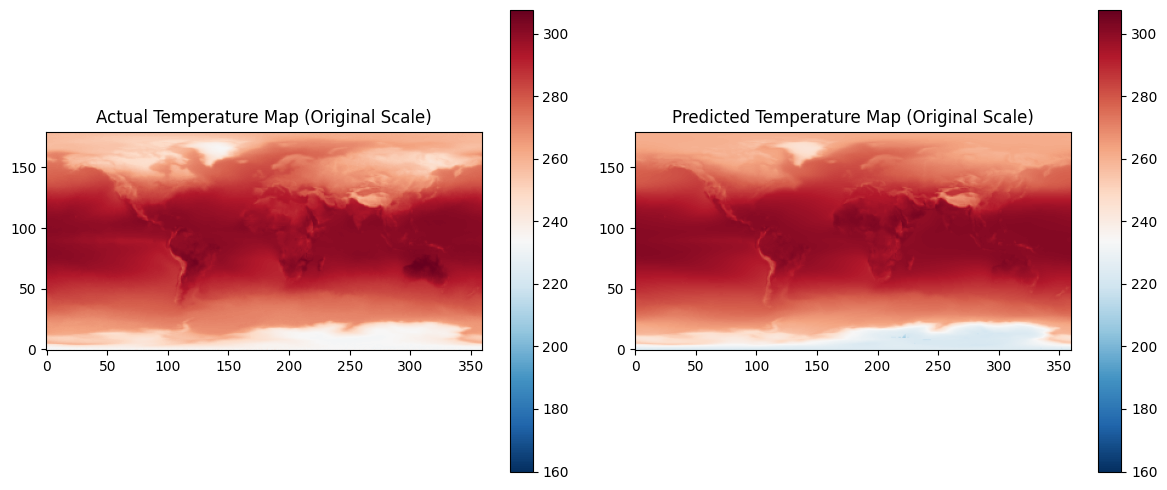

In [132]:
import matplotlib.pyplot as plt

# Choose a time step to visualize (e.g., first time step)
time_step_index = 0


# Determine the common color scale limits based on the actual data
common_vmin = min(y_test_reshaped[time_step_index].min(), y_pred_original_scale[time_step_index].min())
common_vmax = max(y_test_reshaped[time_step_index].max(), y_pred_original_scale[time_step_index].max())

# Plot actual temperature map
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(y_test_reshaped[time_step_index].reshape((180, 360)), cmap='RdBu_r', vmin=160, vmax=common_vmax)
plt.title('Actual Temperature Map (Original Scale)')
plt.gca().invert_yaxis()
plt.colorbar()

# Plot predicted temperature map
plt.subplot(1, 2, 2)
plt.imshow(y_pred_reshaped[time_step_index], cmap='RdBu_r', vmin=160, vmax=common_vmax)
plt.title('Predicted Temperature Map (Original Scale)')
plt.colorbar()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## CNN-LSTM Hyperparameter Tuning

In [133]:
minibatch_size = 64
num_epochs     = 80
n_trials       = 10   # total number of trials in hyperparameter tuning
n_filters   = 20 # number of filters
kernel_size = 3  # kernel size for Covolutional layers
#pool_size   = 2  # size for average pooling layers
activation  = 'relu' # activation function
learning_rate = 0.001 # learning rate
minibatch_size = 10   # batch size
num_epochs     = 300   # number of total epochs

In [134]:
def build_model(hp):

    # options for hyperparameters
    hp_filters = hp.Choice('filters', values=[16,32,64])
    hp_kernel_size = hp.Choice('kernel_size', values=[2,3,4,5])
    hp_pool_size = hp.Choice('pool_size', values=[2,3,4,5])
    hp_activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    hp_loss = hp.Choice('loss', values=['mse','mae'])

    # build CNN models according to the hyperparameters
    model_cnn_lstm = keras.models.Sequential()

    model_cnn_lstm.add(Input(shape=(sequence_length, n_lat,n_lon,n_feature)))
    model_cnn_lstm.add(TimeDistributed(Conv2D(hp_filters, (kernel_size, kernel_size), padding='same', activation=hp_activation), input_shape=(sequence_length, n_lat,n_lon,n_feature)))
    model_cnn_lstm.add(TimeDistributed(AveragePooling2D(pool_size)))
    model_cnn_lstm.add(TimeDistributed(GlobalAveragePooling2D()))
    model_cnn_lstm.add(LSTM(n_lstm_unit, activation=hp_activation))
    model_cnn_lstm.add(Dense(n_lat*n_lon))
    model_cnn_lstm.add(Activation('linear'))
    model_cnn_lstm.add(Reshape((1, n_lat, n_lon)))

    model_cnn_lstm.compile(loss=hp_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate))

    return model_cnn_lstm

In [135]:
!pip install keras-tuner --upgrade

In [136]:
import keras_tuner

In [137]:
# Instantiate the Tuner and save the trials in a directory with customized project name
random_tuner = keras_tuner.RandomSearch(build_model,
                                        max_trials=n_trials,
                                        seed=5,
                                        objective='val_loss',
                                        max_retries_per_trial=0,
                                        max_consecutive_failed_trials=3,
                                        directory='random_search',
                                        project_name='random_search_CNN_LSTM')

In [138]:
random_tuner.search_space_summary()

Search space summary
Default search space size: 6
filters (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
kernel_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 4, 5], 'ordered': True}
pool_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 4, 5], 'ordered': True}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001, 1e-05], 'ordered': True}
loss (Choice)
{'default': 'mse', 'conditions': [], 'values': ['mse', 'mae'], 'ordered': False}


In [139]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
# Perform hypertuning
random_tuner.search(X_train, y_train,
                    batch_size = minibatch_size,
                    epochs = num_epochs,
                    validation_split = 0.2,
                    callbacks = [early_stop])

Trial 7 Complete [00h 04m 54s]
val_loss: 237.90248107910156

Best val_loss So Far: 4.447134017944336
Total elapsed time: 00h 29m 39s

Search: Running Trial #8

Value             |Best Value So Far |Hyperparameter
32                |32                |filters
4                 |4                 |kernel_size
2                 |2                 |pool_size
tanh              |relu              |activation
0.01              |0.0001            |learning_rate
mae               |mae               |loss

Epoch 1/300
5/5 [==============================] - 4s 355ms/step - loss: 278.5551 - val_loss: 278.5518
Epoch 2/300
5/5 [==============================] - 1s 187ms/step - loss: 278.3448 - val_loss: 277.9539
Epoch 3/300
5/5 [==============================] - 1s 187ms/step - loss: 277.4773 - val_loss: 276.7330
Epoch 4/300
5/5 [==============================] - 1s 187ms/step - loss: 276.1378 - val_loss: 275.3012
Epoch 5/300
5/5 [==============================] - 1s 195ms/step - loss: 274.7057 - va

In [ ]:
# display the model structure with the best tuning
best_model = random_tuner.get_best_models()[0]
best_model.summary()

In [ ]:
# check hyperparameters of the all tuning trials
all_hps = random_tuner.get_best_hyperparameters(num_trials=n_trials)

# print the hyperparameters of the top 3 tuning trials
for it in range(3):
    print("Ranking #", str(it+1).zfill(1), "of best tuning, total trials = ", str(n_trials))
    print(all_hps[it].values)
    print("=============================================================================================")


# get the hyperparameters of the best tuning trial
best_hps = random_tuner.get_best_hyperparameters(num_trials=n_trials)[0]

# get the hyperparameters of the second ranking tuning trial
top2_hps = random_tuner.get_best_hyperparameters(num_trials=n_trials)[1]

In [ ]:
## Build the model with the optimal hyperparameters
# ---------- best tuning ----------
model_best = random_tuner.hypermodel.build(best_hps)

# ---------- ranking #2 tuning ----------
model_top2 = random_tuner.hypermodel.build(top2_hps)



## re-train the model
# ---------- best tuning ----------
history_best = model_best.fit(X_train, y_train,
                              batch_size      = minibatch_size,
                              epochs          = num_epochs,
                              validation_split= 0.2,
                              verbose         = 1,
                              callbacks       = [early_stop])
# ---------- ranking #2 tuning ----------
history_top2 = model_top2.fit(X_train, y_train,
                              batch_size      = minibatch_size,
                              epochs          = num_epochs,
                              validation_split= 0.2,
                              verbose         = 1,
                              callbacks       = [early_stop])


In [ ]:
## set up title and ylabel strings
# ---------- best tuning ----------
title_best = 'loss: '+str(best_hps['loss'])
ylabel_best = best_hps['loss']
# ---------- ranking #2 tuning ----------
title_top2 = 'loss: '+str(top2_hps['loss'])
ylabel_top2 = top2_hps['loss']


## plot history
# ---------- best tuning ----------
plt.subplot(1, 2, 1)
plt.plot(history_best.history['loss'])
plt.plot(history_best.history['val_loss'])
plt.title(title_best, fontsize=12)
plt.ylabel(ylabel_best)
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], fontsize=10, loc='upper right')

# ---------- ranking #2 tuning ----------
plt.subplot(1, 2, 2)
plt.plot(history_top2.history['loss'])
plt.plot(history_top2.history['val_loss'])
plt.title(title_top2, fontsize=12)
plt.ylabel(ylabel_top2)
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], fontsize=10, loc='upper right')


## Testing model

In [ ]:
y_pred = model_best.predict(X_test)

1/1 [==============================] - 1s 755ms/step


In [ ]:
y_pred.shape

(16, 1, 180, 360)

In [ ]:
y_pred_reshaped = y_pred.reshape((y_test.shape[0], 180, 360))
y_test_reshaped= y_test.reshape((y_test.shape[0], 180, 360))

In [ ]:
y_pred_reshaped.shape

(16, 180, 360)

In [ ]:
y_test.shape

(16, 1, 180, 360)

In [ ]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test_reshaped[0], y_pred_reshaped[0])
print(f"R^2 Score: {r2}")

R^2 Score: 0.937448161095308


In [ ]:
#Change of scale
#y_test_original_scale = (y_test_reshaped * std2) + mean2
y_pred_original_scale = (y_pred_reshaped * std) + mean

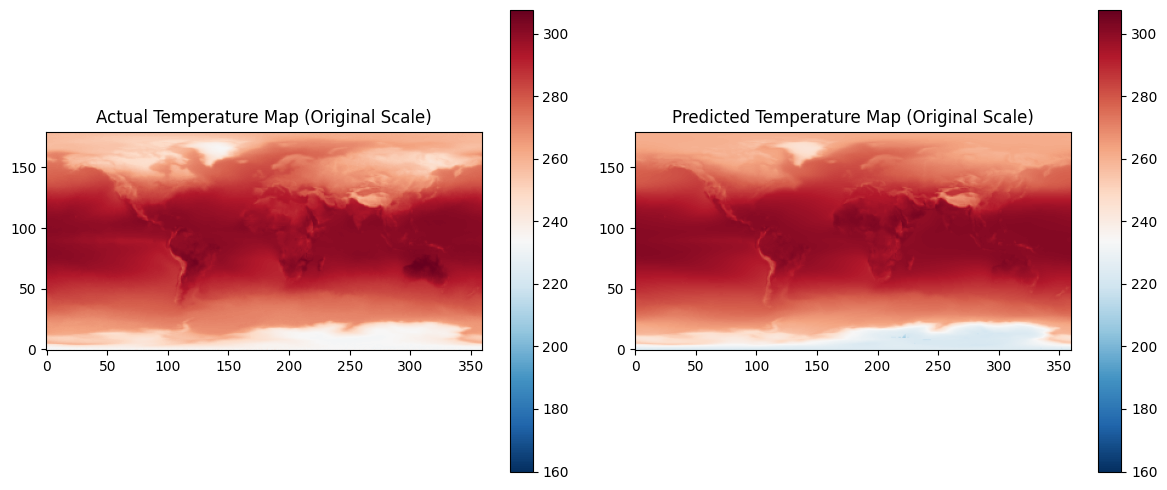

In [ ]:
import matplotlib.pyplot as plt

# Choose a time step to visualize (e.g., first time step)
time_step_index = 0


# Determine the common color scale limits based on the actual data
common_vmin = min(y_test_reshaped[time_step_index].min(), y_pred_original_scale[time_step_index].min())
common_vmax = max(y_test_reshaped[time_step_index].max(), y_pred_original_scale[time_step_index].max())

# Plot actual temperature map
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(y_test_reshaped[time_step_index].reshape((180, 360)), cmap='RdBu_r', vmin=160, vmax=common_vmax)
plt.title('Actual Temperature Map (Original Scale)')
plt.gca().invert_yaxis()
plt.colorbar()

# Plot predicted temperature map
plt.subplot(1, 2, 2)
plt.imshow(y_pred_reshaped[time_step_index], cmap='RdBu_r', vmin=160, vmax=common_vmax)
plt.title('Predicted Temperature Map (Original Scale)')
plt.colorbar()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()